This project is an IRT (Item Response Theory) project (the midterm of my IRT class) that I carried out in python for fun.
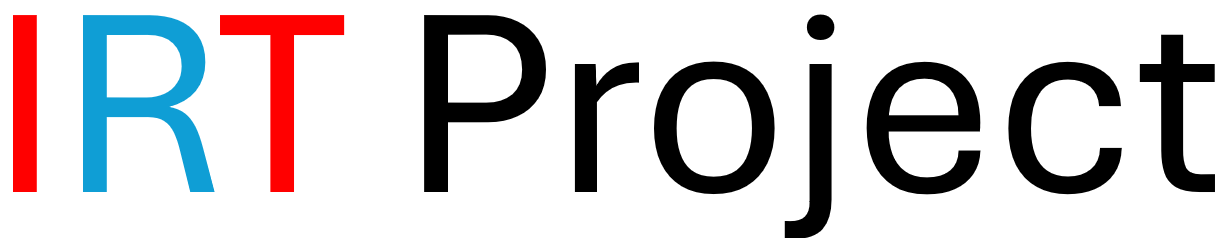

In [138]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pingouin as pg # tests & stats in psychology
from scipy.stats import norm

In [2]:
import os

In [3]:
os.getcwd()

'C:\\Users\\mehoujm\\Downloads\\FLEXMIRT'

In [4]:
# Read in the data set 

amex1920 = pd.read_csv("amex1920.dat", sep = " ", skipinitialspace = True, names = ["I" + f"{i}" for i in range(1,41)], header = None)

amex1920.head(3)

I1  I2  I3  I4  I5  I6  I7  I8  I9  I10  ...  I31  I32  I33  I34  I35  I36  \
1   1   0   0   0   1   0   1   1   0    1  ...    0    0    0    0    1    0   
2   1   1   1   0   1   1   1   1   1    1  ...    0    1    0    0    0    1   
3   1   0   0   0   1   0   1   1   1    0  ...    0    1    0    0    0    0   

   I37  I38  I39  I40  
1    0    1    1    0  
2    0    0    0    0  
3    0    0    1    0  

[3 rows x 40 columns]

In [5]:
# Get the descriptives stats to check weird values

freq = [amex1920["I"+str(i)].value_counts() for i in range(1,41)]

# This loop check if a given list of potiential values for each item is different from [0,1]
# If one is different that would mean that a there are values different from [0,1] I should pay attention to.

for i in freq:
    if (sorted(freq[0].index) != [0, 1]):
        print(i)

### Context (brief)


The **American Experience test** is a 40-item multiple-choice assessment created by faculty to assess the following learning outcomes. 

- Social and political processes and structures using quantitative and qualitative data.
- Primary sources from diverse perspectives relating to American history, political institutions and
society.
- The evolution of intellectual concepts shaping American democratic institutions, including issues
involving power, inequity, and justice.
- The complexity and diversity of American politics, society and culture.
- Intentions and consequences of America’s engagement in global affairs.
- How the historical exclusion of various social identities influences political, social, cultural and
economic development.


It is administered to a random sample of students twice during their academic career: once as incoming first-year students during an institution-wide Assessment Day in August (Pre) and again as students with 45-70 credit hours during Assessment Day in February (Post). 

### The Goal

The goal of this short project (for learning puposes) is to calibrate item and person parameters after checking key assummption and explore the SE and information.

#### Checking the assumptions

##### Model choice: 1, 2, or 3 PL.
Here I'm trying to explore which model would fit best the data. A 1PL a 2PL OR A 3PL
A 1 parameter model is a model that assumes that only one parameter to change across items: the item difficulty. In a 1pl the item discrimination is estimated such that it is constant across all items.
A 2 PL however, assumes that the item discrimination is different for each item. In that model therefore, both the item difficulty and the item discrimination are estimated for each item
A 3 PL adds a third parameter, the guessing parameter estimated for each item to control for correct responses due to chance.


I'll use a visual approach to investigate the necessity of adding a given parameter, i.e. using a more complex model and then estimate the three models and compare their deviance. Hopefully the results I observe visually are coroborated by the results of the Deviance comparison.

###### Visually inspecting the need of the c-parameter

In [6]:
# Get total score for each examinee
amex1920["total"] = amex1920.sum(axis = 1)
amex1920.head(3)

I1  I2  I3  I4  I5  I6  I7  I8  I9  I10  ...  I32  I33  I34  I35  I36  I37  \
1   1   0   0   0   1   0   1   1   0    1  ...    0    0    0    1    0    0   
2   1   1   1   0   1   1   1   1   1    1  ...    1    0    0    0    1    0   
3   1   0   0   0   1   0   1   1   1    0  ...    1    0    0    0    0    0   

   I38  I39  I40  total  
1    1    1    0     19  
2    0    0    0     22  
3    0    1    0     19  

[3 rows x 41 columns]

In [7]:
amex1920.shape

(1708, 41)

In [187]:
# Compute the percent correct on each item to get difficult items
item_diffi = (amex1920.sum(axis = 0) / 1708).sort_values()
item_diffi.tail(6) # These are the 6 most difficult items (based on the percent of correct on the items)

I6        0.836651
I28       0.859485
I24       0.876464
I7        0.903981
I5        0.912763
total    23.182670
dtype: float64

In [214]:
# Here I'm trying to plot a scatter plot between each item responses (across individuals) and the total score variable.
# But I want the points on the scatter to reflect the density of people at each intersection between a given total score 
# and an item response. 

fig, ax = plt.subplots(3, 3, figsize=(150, 60)) # create the structure of the plot

dict = {}  

for count, i in enumerate(list(item_diffi[:9].index), start = 0): # using the most 10 difficult items

    # These two below will help move across rows and cols
    row = count // 3 # integer result of the division
    col = count % 3  # remainder of the division

    
    to_plot1 = amex1920.loc[: , ["total"] + [i]].value_counts() # get the crosstabulated counts between a given item and the variable "total"
    to_plot2 = pd.DataFrame({"index" : to_plot1.index, "val" : to_plot1.values}) # put the indexes in a Df with the values
    to_plot2["total"] = to_plot2["index"].str[0] # Extract the total values
    to_plot2[i] = to_plot2["index"].str[1] # Extract the index
    dict[i] = to_plot2 # Adding each time to a dictionary just in case I need it later
    # Plotting
    ax[row, col].scatter(dict[i]["total"], dict[i][i], s = 100*dict[i]["val"],alpha = 0.8,  c = "purple") 
    ax[row, col].set_title(i, fontsize=100)
    ax[row, col].tick_params(axis = "both", which = "major", labelsize=40)

plt.show()

An examination of Figure 1 shows that, some students with total score lower that 15 out of 40 (we can consider as having an overall lower ability) got some of these difficult items correct. These items are the 10 most difficult. Let's get precise numbers:

In [218]:
pd.DataFrame([(i, amex1920.loc[amex1920["total"] <= 15 , i].sum())  for i in list(item_diffi[:9].index)])

0   1
0  I34  39
1  I35  29
2  I38  34
3   I3  35
4   I9  41
5  I36  48
6  I37  23
7   I4  44
8  I31  36

That justifies integrating a c parameter (guessing parameter) into the model to account the base chance that every student has of getting the item correct by pure guessing.

Now that I visually checked the inclusion of the c-parameter, let's check whether the inclusion of the discrimination parameter such that it varies across items is justified. For that I check the point biserial correlation between each item response and the total score. Differing item total correlations would indicate that the way each item separates between examinees of higher ability and those of lower ability is different across items, which would imply that the item discrimination differs across items

In [11]:
# Check for different slopes
# Compute the point biserial for each item (Which is just the pearson correlation, wanted to play with that)

def pointbiserial (x_bin, y_cont):
    data = pd.DataFrame({"x_bin" : x_bin, "y_cont": y_cont})
    m1 = data.loc[data["x_bin"] == 0, "y_cont"].mean()
    m2 = data.loc[data["x_bin"] == 1, "y_cont"].mean()
    p = (data["x_bin"].sum())/len(data)
    mean_diff = (m2 - m1)
    sd = np.std(y_cont)
    biserial = (mean_diff/sd)*((p*(1-p))**(1/2))
    return biserial

In [12]:
# Get the correlations for between items and the total score
corr = pd.Series([pointbiserial(amex1920[i], amex1920["total"]) for i in list(amex1920.columns[:-1])], index = list(amex1920.columns[:-1]))
corr.head()

I1    0.393045
I2    0.160653
I3    0.302154
I4    0.306245
I5    0.251239
dtype: float64

In [13]:
# To get a rough idea of how the item total correlations are distributed, let's plot a histogram

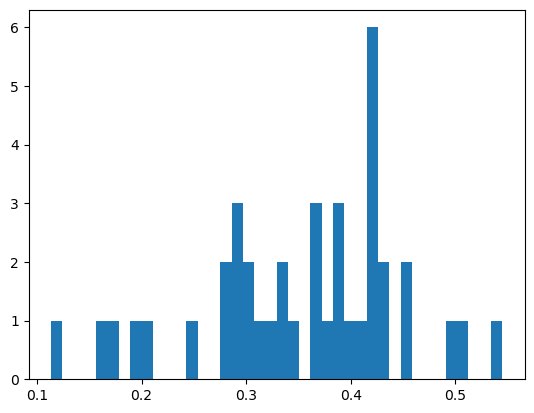

In [14]:
#Histogram
plt.hist(corr, bins = 40)
plt.show()

It can be observed that the range of correlation is between 0.1 and 0.7. I conclude therefore, that (at least visually), integrating a discrimination parameter that varies across item is justified.

From the above, the 3-PL will therefore, likely fit better the data than a 2PL or a 1PL. To verify that numerically, let's calibrate the model for the 1pl, 2pl and 3PL and compare their deviance. The deviance, equal to -2logLikelihood is a measure of misfit; that is, the lower the better the model. We would therefore expect the 3PL to have the lowest deviance to corroborate our conclusions from the visual exploration

For the purpose of this learning project, I calibrated the three models in FlexMirt

**3PL**

Statistics based on the loglikelihood of the fitted model:\
                         -2loglikelihood:    **77894.73**\
      Akaike Information Criterion (AIC):    **78134.73**\
    Bayesian Information Criterion (BIC):    **78787.90**
      
**2PL**\
Statistics based on the loglikelihood of the fitted model:\
                         -2loglikelihood:    **77979.98**\
      Akaike Information Criterion (AIC):    **78139.98**\
    Bayesian Information Criterion (BIC):    **78575.43**

**1PL**\
Statistics based on the loglikelihood of the fitted model:\
                         -2loglikelihood:    **79020.06**\
      Akaike Information Criterion (AIC):    **79102.06**\
    Bayesian Information Criterion (BIC):    **79325.22**

In [15]:
deviance = pd.DataFrame({"-2LL": [77894.73, 77979.98,79020.06] , "AIC": [78134.73, 78139.98, 79102.06], "BIC": [78787.90, 78575.43, 79325.22]}, 
             index = ["3PL", "2PL", "1PL"])

deviance.head()

-2LL       AIC       BIC
3PL  77894.73  78134.73  78787.90
2PL  77979.98  78139.98  78575.43
1PL  79020.06  79102.06  79325.22

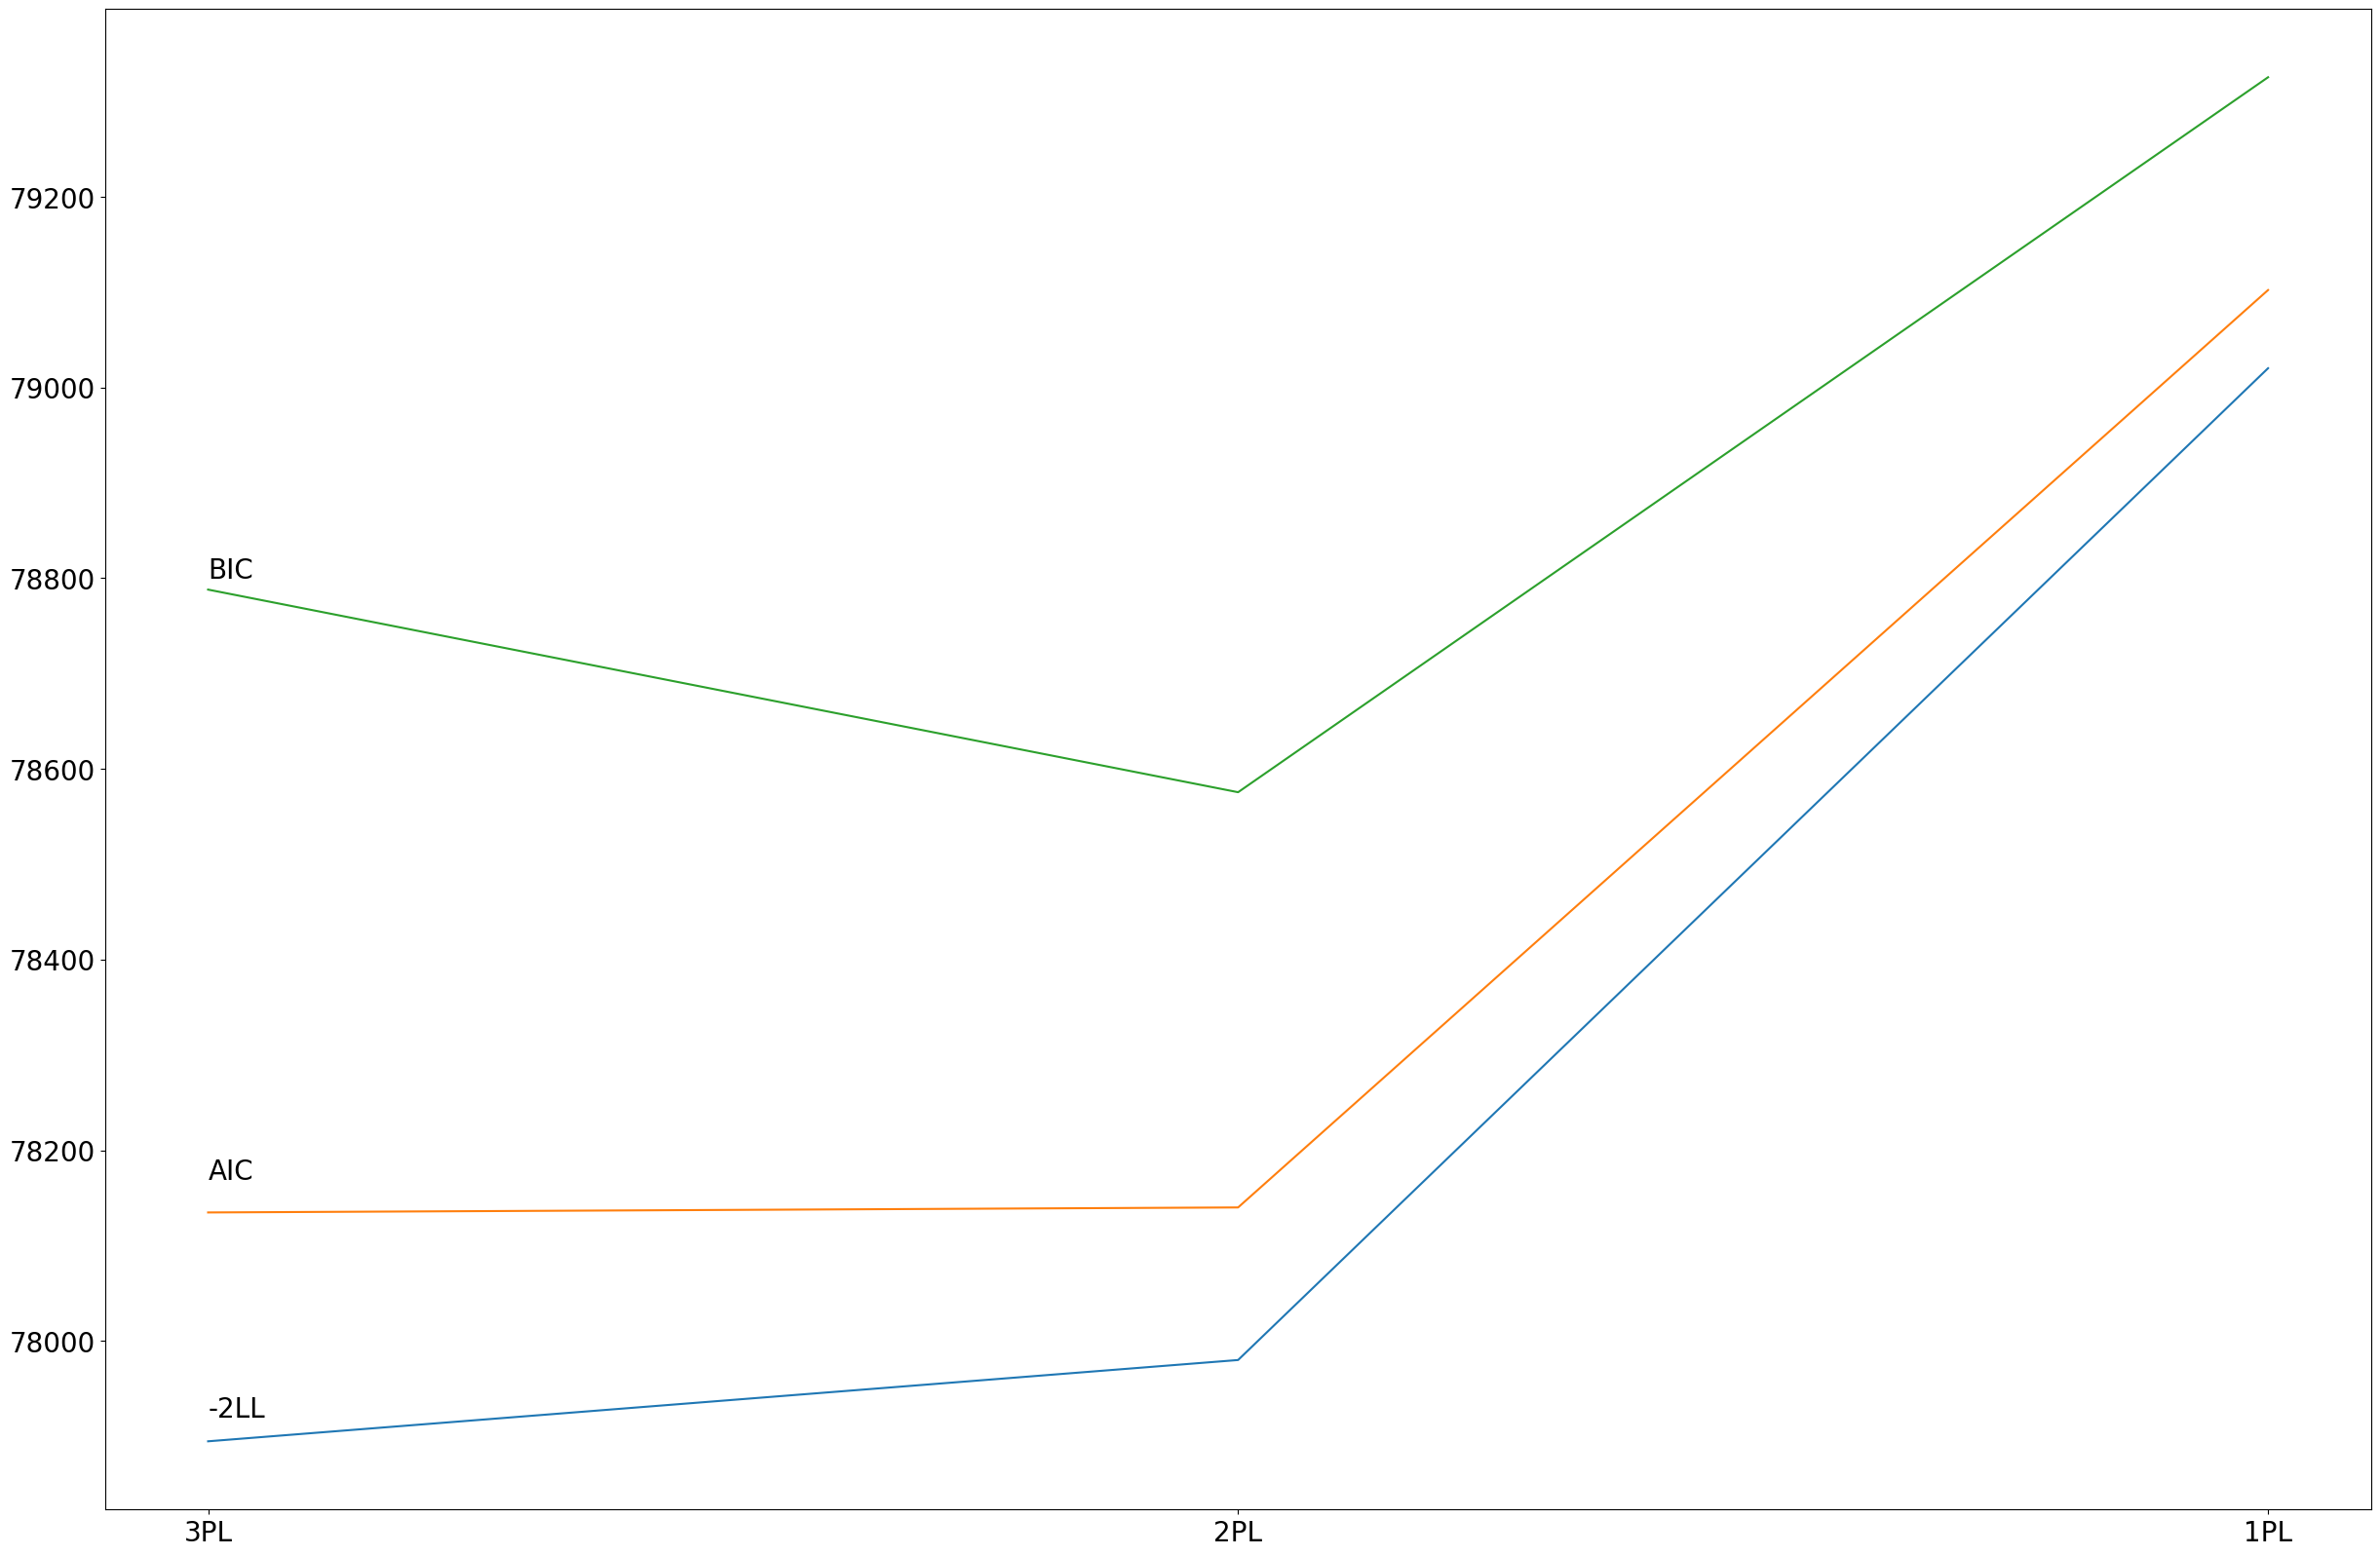

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(30, 20)) # create the structure of the plot

for i in deviance.columns:    
    ax.plot(deviance[i])

ax.text(0, 77920 , "-2LL", size = 20)
ax.text(0, 78170 , "AIC", size = 20)
ax.text(0, 78800 , "BIC", size = 20)
ax.tick_params(axis = "both", which = "major", labelsize=20)

As one can see in the graph above, the 3PL’s `-2LL` and `AIC` (correcting for number of parameters - model complexity) are lower than those of the 2PL the 1PL, which corroborate our observation from the visuals above.

However, the 2PL’s `BIC` is lower than that of the 3PL. We know the `BIC` is harsher in its correction for the model complexity as it replaces 2*number of predictors by ln(sample_size) *number of predictors.  And because ln (8) > 2, as long as the sample size is higher than 8, it will be harsher on models with higher number of parameters than the the `AIC`. In our case the sample size is 1708.

Therefore, we'll proceed with the 3PL.

##### Let's now explore the item fit, that is how the postulated model fit the data for each item
Again, here too, we'll proceed visually and then look at Orlando-Thissen test which is a numeric systematic way of evaluating the fit for each item. It is a correction of Yen's Q1 or Bock's Chi2 (that has crazy type 1 error rates)

Proceeding with the 3PL, let's draw two ICCs for each item : one empirical and another one purely for the predicted probability from the model. 
One precision here is that the parameters estimated from the 3PL in logistic metric (in FLEXMIRT) are on the logistic metric.

In [155]:
# Import 3PL item calibration file that contains the items parameters

item_cal = pd.read_csv(r"C:\Users\mehoujm\Downloads\FLEXMIRT\Midterm\3PL AMEX-item calibration.txt", sep = " ", skipinitialspace = True, 
         names = ["Item", "a", "c", "b", "logit-g", "g"])
item_cal.head()

Item     a     c     b  logit-g     g
0     1  1.21  1.35 -1.12    -1.82  0.14
1     2  0.28 -0.47  1.68    -1.57  0.17
2     3  0.89 -1.18  1.33    -1.71  0.15
3     4  0.99 -1.14  1.15    -1.52  0.18
4     5  0.93  2.47 -2.65    -1.70  0.15

Here g is the guessing parameter, a the discrimination parameter and b the difficulty parameter. The next cell extracts each of them from the dataset

In [156]:
c = item_cal["g"].to_numpy()[:, np.newaxis] # Extract the guessing parameter
a = item_cal["a"].to_numpy()[:, np.newaxis] # Extract the discrimination parameter
b = item_cal["b"].to_numpy()[:, np.newaxis] # Extract the difficulty parameter

print(c.shape)
print(a.shape)
print(b.shape)

(40, 1)
(40, 1)
(40, 1)


Now let's get the quadrature points. Why? \
The goal of this part is to get the empirical and theoretical Item characteristics curves. These ICCs plot the probability of correctly answering an item against the ability continuum. The assumption about the distribution of that continuum (hypothetically from which the students are drawn from) is that it follows a normal distribution of mean 0 and variance 1.

So, for a given item, plotting the theoretical ICC will consist in replacing all the ability values along the continuum in the formula of the probability of answering the item correctly. 

Instead of doing that, we can get discrete values distributed along that continuum and their associated weight (their probability) to reconstitute the distribution without going over all the possible values which is of course impossible (unless dealt with algebraically). Those points are called quadrature points. And we'll use them for the theoretical probabilities for each item, but also for the "observed" probabilities (More on that later). 


In [157]:
# Get 1001 quadrature points between -4 and 4.
theta_quad = np.linspace(-4,4,1001) # 
quadwgt = norm.pdf(theta_quad) 
quadwgt = quadwgt/np.sum(quadwgt)
quadwgt

array([1.07070849e-06, 1.10548988e-06, 1.14132808e-06, ...,
       1.14132808e-06, 1.10548988e-06, 1.07070849e-06])

In [158]:
# Let's transform the item responses to a numpy dataset to make matrices operations easier
responses = amex1920.iloc[:, :-1].to_numpy() # Omit the last column because it contains the total

responses.shape

(1708, 40)

In [159]:
# Matrix for a given individual, containing the probability of a correct answer on each item by quadrature point interaction 
#(This is the theoretical probability matrix). That is what the model predicts for each item at each ability point.

matrix_prob_1_ind = (c + ((1-c) * (1/(1 + np.exp(-a*(theta_quad - b))))))
matrix_prob_1_ind.shape

(40, 1001)

Each row represents a quadrature. So for instance when the quadrature is 4, the probability of correctly answering the items is matrix_prob_1_ind[0], which is of length the number of items.

Now, that we have the theoretical probability, let's go get the "observed probability" of correctly answering the items AT EACH QUADRATURE POINT.

Another way: Given the data observed, what is the probability of answering correctly a given item; which is a description for the posterior distribution at each quadrature point for each item, given the data.

We need therefore 
 - the likelihood at each quadrature
 - The weigh of each quadrature\
Those two will help find the numerator of the posterior formula
 - And we need the sum across items for each quadrature to get the denominator (the marginal likelihood)



In [22]:
# let;s compute the likelihood for each individual item response (for all items and individuals) for each quadrature point.

# first, need to make matrices broadcastable by transforming them in 3D matrices (Look at the video i recorded)
matrix_right_quad = matrix_prob_1_ind[:, np.newaxis, :]
resp2 = responses.T[:, :,np.newaxis]

print(matrix_right_quad.shape)
print(resp2.shape)

(40, 1, 1001)
(40, 1708, 1)


In [23]:
# Next, apply p**x * (1-p)**1-x to obtain probabilities across quadrature points, individuals and items

final_matrix = (matrix_right_quad**resp2) * ((1 -matrix_right_quad)**(1-resp2))
final_matrix.shape

(40, 1708, 1001)

In [24]:
# Next, let's get the matrix of likelihoods for each individual and quadrature points across items (multiply the probabilities across items)

likelihoods_across_items = np.prod(final_matrix, axis = 0)
likelihoods_across_items.shape

(1708, 1001)

In [25]:
# Next, since we used quadrature points to approximate a normal dist, we need to weight each by its prob (quadrature weight)
quadwgt_broad = quadwgt[np.newaxis, :]
quadwgt_broad.shape
weighed_likelihoods_across_items = quadwgt_broad*likelihoods_across_items
weighed_likelihoods_across_items.shape

(1708, 1001)

In [26]:
# The whole idea of these gymnastics was to estimate an average prob of observing the item response
# given diferent quadrature points which is the posterior distribution, i.e. the updated posterior distribution of the quadratures given the data

posterior_distribution_quadratures = weighed_likelihoods_across_items/np.sum(weighed_likelihoods_across_items, axis = 1)[:,np.newaxis]
posterior_distribution_quadratures.shape

(1708, 1001)

In [27]:
# Now we can get the "new" observed probability of correctly answering a given item 

# For that, we'll first re-obtain for all items and for all individuals for each quadrature points the data with that new distribution
# of the quadrature points

#First, Make the posterior_distribution_quadratures  broadcastable 
posterior_distribution_quadratures_broad = posterior_distribution_quadratures[np.newaxis, :,:]
print(posterior_distribution_quadratures_broad.shape)
print(resp2.shape)

(1, 1708, 1001)
(40, 1708, 1)


In [28]:
# We don't care much about the (new) probability of NOT answering the item correctly because our goal is to 
# get the probability of correctly answering an item which can be obtained by summing p for all the values where
# a correct answer was found divided by the sum of p across the number of people. 


obs_prob_correct = np.sum((posterior_distribution_quadratures_broad * resp2), axis = 1) 
obs_prob_correct.shape

denom = np.sum(posterior_distribution_quadratures, axis = 0)[np.newaxis, :]

obs = obs_prob_correct/denom
obs 

array([[0.05381208, 0.05402895, 0.05424812, ..., 0.99992793, 0.99993038,
        0.99993276],
       [0.55809929, 0.55839675, 0.55869111, ..., 0.98644373, 0.98667364,
        0.98689981],
       [0.3275056 , 0.32681115, 0.32611613, ..., 0.88924559, 0.88964058,
        0.89003363],
       ...,
       [0.21167205, 0.21194299, 0.21221476, ..., 0.99379014, 0.9938863 ,
        0.99398112],
       [0.23539086, 0.23540182, 0.23541149, ..., 0.85719134, 0.85713067,
        0.85707289],
       [0.03942448, 0.03962509, 0.03982765, ..., 0.97810542, 0.97844404,
        0.9787781 ]])

Now, we can plot the "observed" or empirical ICC (in red) and the theoretical in blue

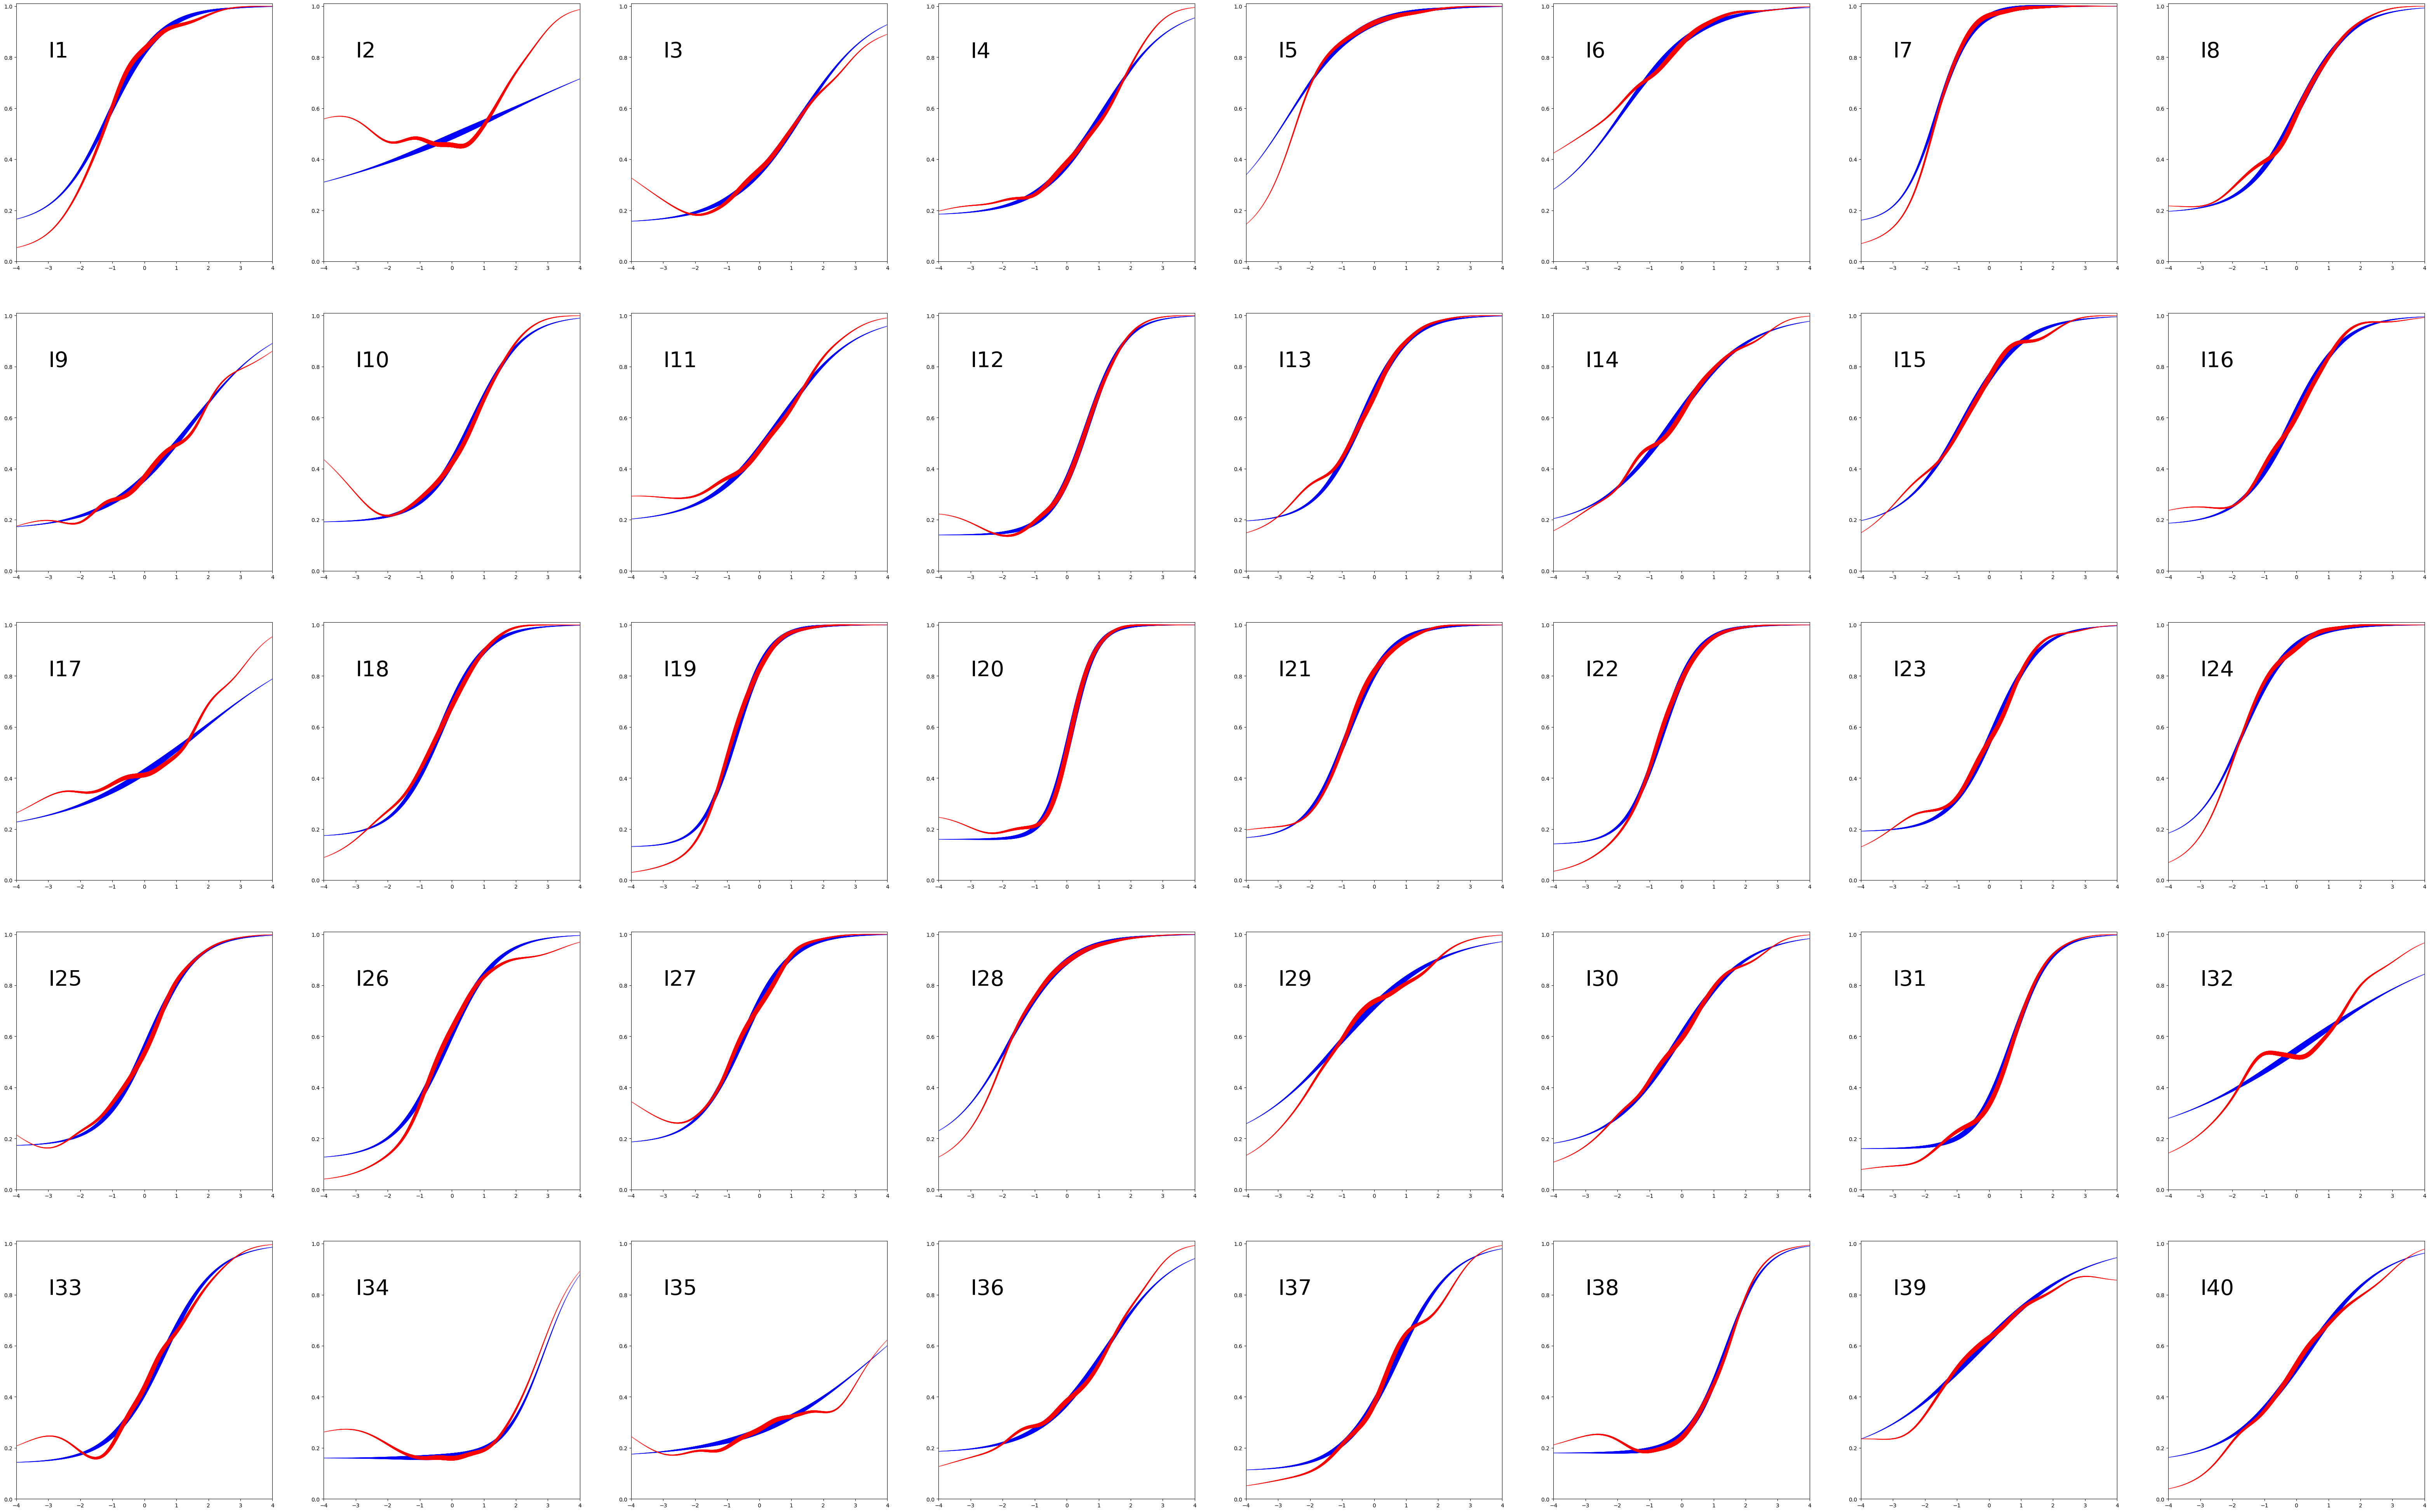

In [29]:
fig , ax = plt.subplots(5, 8, figsize=(80, 50))

for count, i in enumerate(matrix_prob_1_ind):
    row = count // 8 # a really cool way to move from a row to the other
    col = count % 8
    item = "I" + str(count+1)
    ax[row, col].scatter(theta_quad, i[np.newaxis, :], s = 30000*quadwgt, c = "blue") # I weighted by the default quadrature weights
    ax[row, col].scatter(theta_quad, obs[count,:] , s = 10*denom, c = "red") # I weighted the obs by the vector of weighted posterior density across at each quadrature

    ax[row,col].text(-3, 0.8 , item, size = 40)    
    ax[row,col].axis(xmin = -4, xmax = 4, ymin = 0, ymax = 1.01)


From the plot above, one can see that Item2, item 17, item 26, item 32, item35 and item 37 seemed not well fitted by the model. 

Let's look at the Orlando-Thissen statistic and pvalues

In [30]:
# Import the orlando thissen from FLEXMIRT
OTB = pd.read_csv(r"C:\Users\mehoujm\Downloads\FLEXMIRT\Midterm\Orlando-thissen 3pl.txt", sep = ",", header = None)
OTB.head()

0            1
0    Item 1 S-X2(25) = 33.2   p = 0.1270
1    Item 2 S-X2(31) = 55.5   p = 0.0044
2    Item 3 S-X2(28) = 33.6   p = 0.2155
3    Item 4 S-X2(29) = 37.3   p = 0.1392
4     Item 5 S-X2(25) = 7.3   p = 0.9998

In [31]:
# Extract from col 1 the values and get the items for which the p-values are lower than 0.01 (non well fitted items)

OTB["p-value"] = OTB[1].str.extract(r"p = ([0-9\.]*)").astype(float)

OTB.loc[OTB["p-value"] < 0.05,:]

0            1  p-value
1      Item 2 S-X2(31) = 55.5   p = 0.0044   0.0044
16    Item 17 S-X2(30) = 45.0   p = 0.0381   0.0381
18    Item 19 S-X2(23) = 36.4   p = 0.0373   0.0373
22    Item 23 S-X2(27) = 42.4   p = 0.0300   0.0300
25    Item 26 S-X2(26) = 50.0   p = 0.0031   0.0031
36    Item 37 S-X2(28) = 60.7   p = 0.0003   0.0003

The p-values for items 2, 17, 19, 23, 26 and 37 have significant p-values which would lead to the rejection of the Null hypothesis that they fit the model.\

In [32]:
pd.DataFrame({"OTB_flagged": ["Item 2", "Item 17", "Item 19", "Item 23", "Item 26", None , None, "Item 37"], 
              "Visually_flagged": ["Item 2", "Item 17", np.nan , np.nan, "Item 26", "Item 32", "Item 35", "Item 37"]})

OTB_flagged Visually_flagged
0      Item 2           Item 2
1     Item 17          Item 17
2     Item 19              NaN
3     Item 23              NaN
4     Item 26          Item 26
5        None          Item 32
6        None          Item 35
7     Item 37          Item 37

Together, both approaches flagged Item 2, 17, 26 and 37 as not fitting the model. If I had access to the test, I would go read the item to get more context...
But for the purposes of this project, I will simply delete these items for the rest of this work.

It is important to note that all the work above was based on the assumption of unidimensionality and local dependence. In other words, I assumed that there is one overarching trait that drives the responses of students on all the items (unidimensionality) and also that the probability of answering correctly a given item is independent of the that answering another item if one controls for that unique ability trait (local independence)


However, let's  use Yen's Q3 to assess local independence. Yen's Q3 is the pearson product correlation between pairs of residuals (for two given items). The residuals on a given item is the observed response minus the probability of the observed response in the model (that assumes unidimensionality).





In [33]:
# Read in the scores
scores = pd.read_csv(r"C:\Users\mehoujm\Downloads\FLEXMIRT\Midterm\3PL AMEX-sco.txt", 
                     header = None, skipinitialspace = True, sep = " ")
theta = scores[2].to_numpy()[np.newaxis, :]
theta.shape

(1, 1708)

In [34]:
b.shape # Making sure broadcastable

(40, 1)

In [35]:
# Using the 3pl we can get for each estimated ability the probability predicted by the model

prob = (c + ((1-c) * (1/(1 + np.exp(-a*(theta - b))))))

prob.shape

(40, 1708)

In [36]:
# Now get the residuals
#   First make sure broadcastable
responses.shape

(1708, 40)

In [37]:
resp3 = responses.T
resp3.shape

(40, 1708)

In [38]:
residuals = resp3 - prob
residuals.shape

(40, 1708)

In [39]:
# Now we can compute Yen's Q3 (two by two correlations between items) from the residuals matrix

Q3 = pd.DataFrame(residuals.T, columns = ["I" + str(i) for i in range(1,41)]).rcorr()
Q3.head()

I1      I2      I3     I4 I5  I6 I7 I8 I9  I10  ... I31 I32 I33 I34  \
I1       -       *                                      ...   *   *   *       
I2   -0.05       -                                 ***  ...                   
I3   0.003   0.029       -                              ...           *       
I4  -0.026   0.037  -0.042      -                       ...                   
I5  -0.002  -0.004  -0.023  0.045  -  **     *          ...          **       

   I35 I36 I37 I38 I39 I40  
I1                          
I2           *              
I3                          
I4                          
I5                          

[5 rows x 40 columns]

In [40]:
# let's get the highest 10 correlations
Q3.stack().sort_values()[-10:]

I35  I13    0.048
I38  I33    0.049
I34  I33    0.049
I32  I29    0.052
I17  I11    0.052
I8   I5     0.053
I39  I35    0.061
I11  I6     0.063
I16  I13    0.081
I10  I2     0.112
dtype: object

The largest value of Yen's Q3 is 0.112 which is lower than the 0.2 cuttoff where we should be alarmed of the violation of local dependence. Therefore, we can conclude that under using the 3PL the assumption of local independence is satisfied.

For the assumption of unidimensionality we'll use the eigen values from the tetrachoric correlations matrix. Why? Because the tetrachoric correlation between two item responses is (by definition) the correlation between the latent continuous bivariate normal variable assumed to be driving the observed values on these variables.  

Therefore, that matrix is akin to the correlation matrix between continuous variables used in component analysis. 
We can, therefore, extract the variance contained in that matrix using eigen values that would indicate the number of factors that explain most of the variability in the correlation matrix. These eigen values would in turn help check the number of principal factors, and therefore, the unidimensionality assumption in the item responses data.

So first, we need the two by two tetrachoric correlations

A great step by step in R is given here https://library.virginia.edu/data/articles/understanding-polychoric-correlation 


##### Me trying to create my function to compute the tetrachoric correlation

In [41]:
from scipy.stats import multivariate_normal
from scipy.optimize import minimize

The goal here is to write the likelihood function as a function of rho and then maximize it. For two given items we assume that the values are generated by a probability function that is a bivariate standard normal distribution (mean = (0,0), var_matrix = [var(x) = 1, var(y) = 1 and cor = rho]

Like always, to compute a likelihood function, we calculate the probability of observed values as if they were generated by the probability function and then find the parameters of the function maximizing the likelihood.

The thing is that, here, we don't have explicitly the values. We can have thresholds for the values and therefore calculate the probabilities for batches of "observed values" USING the CUMULATIVE FUNCTION associated with the bivariate standard normal distribution.

Now, how do we get the thresholds? Well we can approximate them. If we assume that the "observed distribution" for a given item is representative of the theoretical population following a normal distribution, the proportion of each item response (0 or 1) will be the proportions of values less than (0) or higher than (1) a given threshold in the population. And we can back engineer to get that threshold associated with separating the population distribution in these two proportions.

That's what I'm doing below cell:

In [71]:
threshold = norm.ppf(np.mean(1 -responses, axis = 0 ))
print(threshold.shape)
threshold

(40,)


array([-0.77964954,  0.01761188,  0.31632421,  0.23248769, -1.35797043,
       -0.98078679, -1.3045754 , -0.22345036,  0.3009324 ,  0.0955379 ,
        0.01174092,  0.21593321, -0.46370775, -0.31632421, -0.60779186,
       -0.29786269,  0.16214156, -0.43610098, -0.69116579, -0.11176842,
       -0.70239061, -0.59197972, -0.15768216, -1.15748908, -0.15322589,
       -0.25213493, -0.52339044, -1.07800742, -0.55222202, -0.25668249,
        0.23098017, -0.12359072,  0.12506968,  0.90082476,  0.61132626,
        0.24456719,  0.23399573,  0.5049654 , -0.31478171, -0.05285752])

In [116]:
def likelihood (x,y, thresh_x, thresh_y, rho):
    corr = np.array([[1, rho],  
                     [rho, 1]])
    
    rv = multivariate_normal(mean= np.array([0, 0]), cov=corr)
    
    p00 = rv.cdf([thresh_x, thresh_y]) # likelihood for latent values that generated 0s on both x and y
    p01 = rv.cdf([thresh_x, np.inf]) - rv.cdf([thresh_x, thresh_y]) # Likelihood for latent values that generated 0s for x and 1s FOR y 
    p10 = rv.cdf([np.inf, thresh_y]) - rv.cdf([thresh_x, thresh_y]) # Likelihood for latent values that generated 1s for x and 0s FOR y 
    p11 = 1 - rv.cdf([thresh_x, thresh_y]) # # likelihood for latent values that generated 1s on both x and y; rv.cdf(np.inf, np.inf) = 1
    
    # Avoid log(0) by adding a small value epsilon
    eps = 1e-10
    p00 = max(p00, eps)
    p01 = max(p01, eps)
    p10 = max(p10, eps)
    p11 = max(p11, eps)
    # Since we didn't used the actual values we need to weigh each likelihood by the observed number of values in each category
    # Actually we need to take it to the power of that number to get the actual likelihood. But since I want to use log-likelihoods
    # that is log(l**weight) =  weight*log(L)
    w_00 = np.sum((x == 0) & (y == 0))
    w_01 = np.sum((x == 0) & (y == 1))
    w_10 = np.sum((x == 1) & (y == 0))
    w_11 = np.sum((x == 1) & (y == 1))

    loglikelihood= w_00*np.log(p00) + w_01*np.log(p01)  +  w_10*np.log(p10) + w_11*np.log(p11)

    return -loglikelihood

In [117]:
def objective_function(rho):
    return likelihood(responses.T[0], responses.T[1], norm.ppf(1 - np.mean(i)), norm.ppf(1 - np.mean(j)), rho[0])
    
    
# Use scipy.optimize.maximize to find the rho (correlation) that maximizes the loglikelihood (minimizes the negative log-likelihood)
result = minimize( objective_function, 
         x0= [0.5], bounds=[(-1 + 1e-6, 1 - 1e-6)], method='L-BFGS-B')



In [115]:
responses.T[0].shape

(1708,)

In [118]:
x= {}
for i in np.linspace(-1 + 1e-6, 1 - 1e-6, 1000):
    x[i] =  likelihood(responses.T[0], responses.T[1], norm.ppf(1 - np.mean(responses.T[0])), norm.ppf(1 - np.mean(responses.T[1])), i)



In [119]:
pd.Series(x).idxmin()

-0.471471

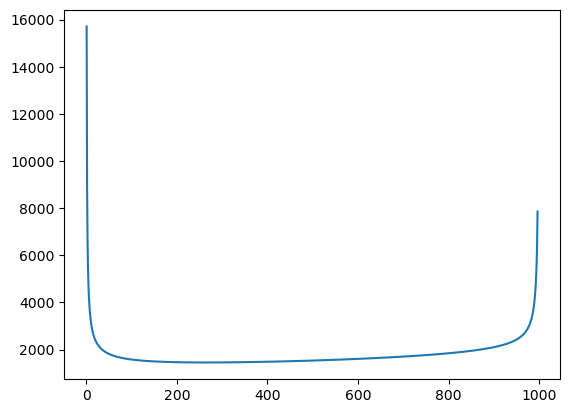

In [113]:
plt.plot(x.values())

In [109]:
likelihood(responses.T[0], responses.T[1], norm.ppf(1 - np.mean(responses.T[0])), norm.ppf(1 - np.mean(responses.T[1])), 0)

1533.8794649716908

In [107]:
objective_function([0])

5900.786825698974

In [102]:
objective_function([0.3])

6169.046643798309

In [80]:
objective_function([0.1])

1709.9645340118577

In [76]:
result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 2023.3422291588547
        x: [ 5.000e-01]
      nit: 1
      jac: [ 1.031e+03]
     nfev: 6
     njev: 3
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

In [73]:
dict = {}
for count1, i in enumerate(responses.T, start = 1):
    for count2, j in enumerate(responses.T, start = 1):
        if not np.array_equal(i, j):
            def objective_function(rho):
                return likelihood(i, j, norm.ppf(1 - np.mean(i)), norm.ppf(1 - np.mean(j)), rho[0])
            # Use scipy.optimize.maximize to find the rho (correlation) that maximizes the loglikelihood (minimizes the negative log-likelihood)
            result = minimize( objective_function, 
                     x0= [0.5], bounds=[(-1 + 1e-6, 1 - 1e-6)], method='L-BFGS-B')
            dict[f"I{count1}, I{count2}"] = rho_tetrachoric = result.x[0]


C:\Users\mehoujm\AppData\Local\Temp\ipykernel_21228\1099572956.py:20: RuntimeWarning: divide by zero encountered in log
  loglikelihood= w_00*np.log(p00) + w_01*np.log(p01)  +  w_10*np.log(p10) + w_11*np.log(p11)


In [74]:
dict

{'I1, I2': 0.5,
 'I1, I3': 0.5,
 'I1, I4': 0.5,
 'I1, I5': 0.5,
 'I1, I6': 0.5,
 'I1, I7': 0.5,
 'I1, I8': 0.5,
 'I1, I9': 0.5,
 'I1, I10': 0.5,
 'I1, I11': 0.5,
 'I1, I12': 0.5,
 'I1, I13': 0.5,
 'I1, I14': 0.5,
 'I1, I15': 0.5,
 'I1, I16': 0.5,
 'I1, I17': 0.5,
 'I1, I18': 0.5,
 'I1, I19': 0.5,
 'I1, I20': 0.5,
 'I1, I21': 0.5,
 'I1, I22': 0.5,
 'I1, I23': 0.5,
 'I1, I24': 0.5,
 'I1, I25': 0.5,
 'I1, I26': 0.5,
 'I1, I27': 0.5,
 'I1, I28': 0.5,
 'I1, I29': 0.5,
 'I1, I30': 0.5,
 'I1, I31': 0.5,
 'I1, I32': 0.5,
 'I1, I33': 0.5,
 'I1, I34': -0.6016692615852337,
 'I1, I35': 0.5,
 'I1, I36': 0.5,
 'I1, I37': 0.5,
 'I1, I38': 0.5,
 'I1, I39': 0.5,
 'I1, I40': 0.5,
 'I2, I1': 0.5,
 'I2, I3': -0.999999,
 'I2, I4': -0.999999,
 'I2, I5': 0.5,
 'I2, I6': 0.5,
 'I2, I7': 0.5,
 'I2, I8': 0.5,
 'I2, I9': -0.999999,
 'I2, I10': -0.4915014396452409,
 'I2, I11': -0.5857190587362028,
 'I2, I12': -0.999999,
 'I2, I13': 0.5,
 'I2, I14': 0.5,
 'I2, I15': 0.5,
 'I2, I16': 0.5,
 'I2, I17': -0.999999,
 'I

In [49]:
result = minimize( objective_function, 
                     x0= [0], bounds=[(-1 + 1e-6, 1 - 1e-6)], method='L-BFGS-B')
rho_tetrachoric = result.x[0]
print(rho_tetrachoric)

0.965030941023975


In [154]:
responses.T[0].all != responses.T[0].all

True

In [ ]:

result = minimize(loglikelihood, x0= 0, bounds=[(-1, 1)], method='L-BFGS-B')

# Optimal value of rho (tetrachoric correlation)
rho_tetrachoric = result.x[0]

print(f"Tetrachoric correlation: {rho_tetrachoric}")

##### Using the eigen values generated by R code from Christine

In [124]:
# Import the eigen values

eigen_val = pd.read_csv(r"C:\Users\mehoujm\Downloads\FLEXMIRT\Midterm\Eigen_values.txt", sep = " ", header = None)

<Axes: >

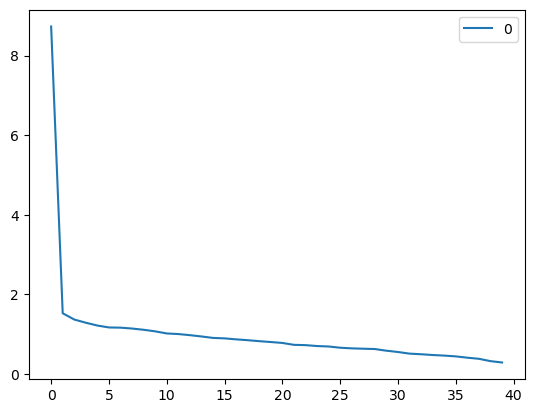

In [128]:
eigen_val.T.plot()

In [131]:
eigen_val.T[:4]

0
0  8.732004
1  1.526289
2  1.367881
3  1.287959

From simply observing the scree plot, there seems to be no second significant factor contributing to the variance in the tetrachoric correlation matrix, because the first drop is massive, and the remaining seems barely significant relative to that. 

Using the Divgi (1980) heuristic rule, the result of the quotient of the difference between the 2nd and 3rd eigen values and the 3rd and 4th 
eigen values is 1.98 which less than 3. Therefore, that rule confirms our finding of unidimensionality.

In [132]:
(1.526289 - 1.367881) / (1.367881 - 1.287959)

1.9820324816696335

Now, we'll explore the information and Standard error of measurement

In [144]:
# Get the information at 1001 quadrature points in from flexMIRT

inf = pd.read_csv(r"C:\Users\mehoujm\Downloads\FLEXMIRT\Midterm\3PL AMEX-inf.txt", sep = "\t", skipinitialspace = True, header = None,  
                  names = ["Grp", "item"] + ["inf" + f"{i}" for i in range(1,1002)] + ["junk"] )
inf.head()

Grp item    inf1    inf2    inf3    inf4    inf5    inf6    inf7    inf8  \
0    1    1  0.0067  0.0068  0.0069  0.0070  0.0072  0.0073  0.0074  0.0075   
1    1    2  0.0050  0.0050  0.0050  0.0050  0.0050  0.0050  0.0050  0.0050   
2    1    3  0.0003  0.0003  0.0003  0.0003  0.0003  0.0003  0.0003  0.0003   
3    1    4  0.0002  0.0002  0.0002  0.0002  0.0002  0.0002  0.0002  0.0002   
4    1    5  0.0821  0.0827  0.0832  0.0838  0.0844  0.0849  0.0855  0.0860   

   ...  inf993  inf994  inf995  inf996  inf997  inf998  inf999  inf1000  \
0  ...  0.0028  0.0028  0.0027  0.0027  0.0027  0.0027  0.0026   0.0026   
1  ...  0.0137  0.0137  0.0137  0.0137  0.0137  0.0137  0.0137   0.0137   
2  ...  0.0539  0.0536  0.0533  0.0530  0.0526  0.0523  0.0520   0.0517   
3  ...  0.0445  0.0442  0.0439  0.0436  0.0433  0.0430  0.0427   0.0424   
4  ...  0.0016  0.0016  0.0015  0.0015  0.0015  0.0015  0.0015   0.0015   

   inf1001  junk  
0   0.0026   NaN  
1   0.0136   NaN  
2   0.0514   NaN  
3   0.0421   NaN  
4   0.0015   NaN  

[5 rows x 1004 columns]

In [160]:
info = inf.iloc[:, 2:-1]
theta = np.linspace(-4,4,1001)
SE = 1/np.sqrt(info)
matrix_prob_1_ind = (c + ((1-c) * (1/(1 + np.exp(-a*(theta_quad - b))))))

The figure below shows in green the ICC, in red the information and in blue the standard error of measurement for 1001 ability points on each item.
It is observable that the information function peaks where the standard error reaches its minimum, which indicates as expected that the ability regions where we have the most information from a given item is the region where our estimates are the most precise.

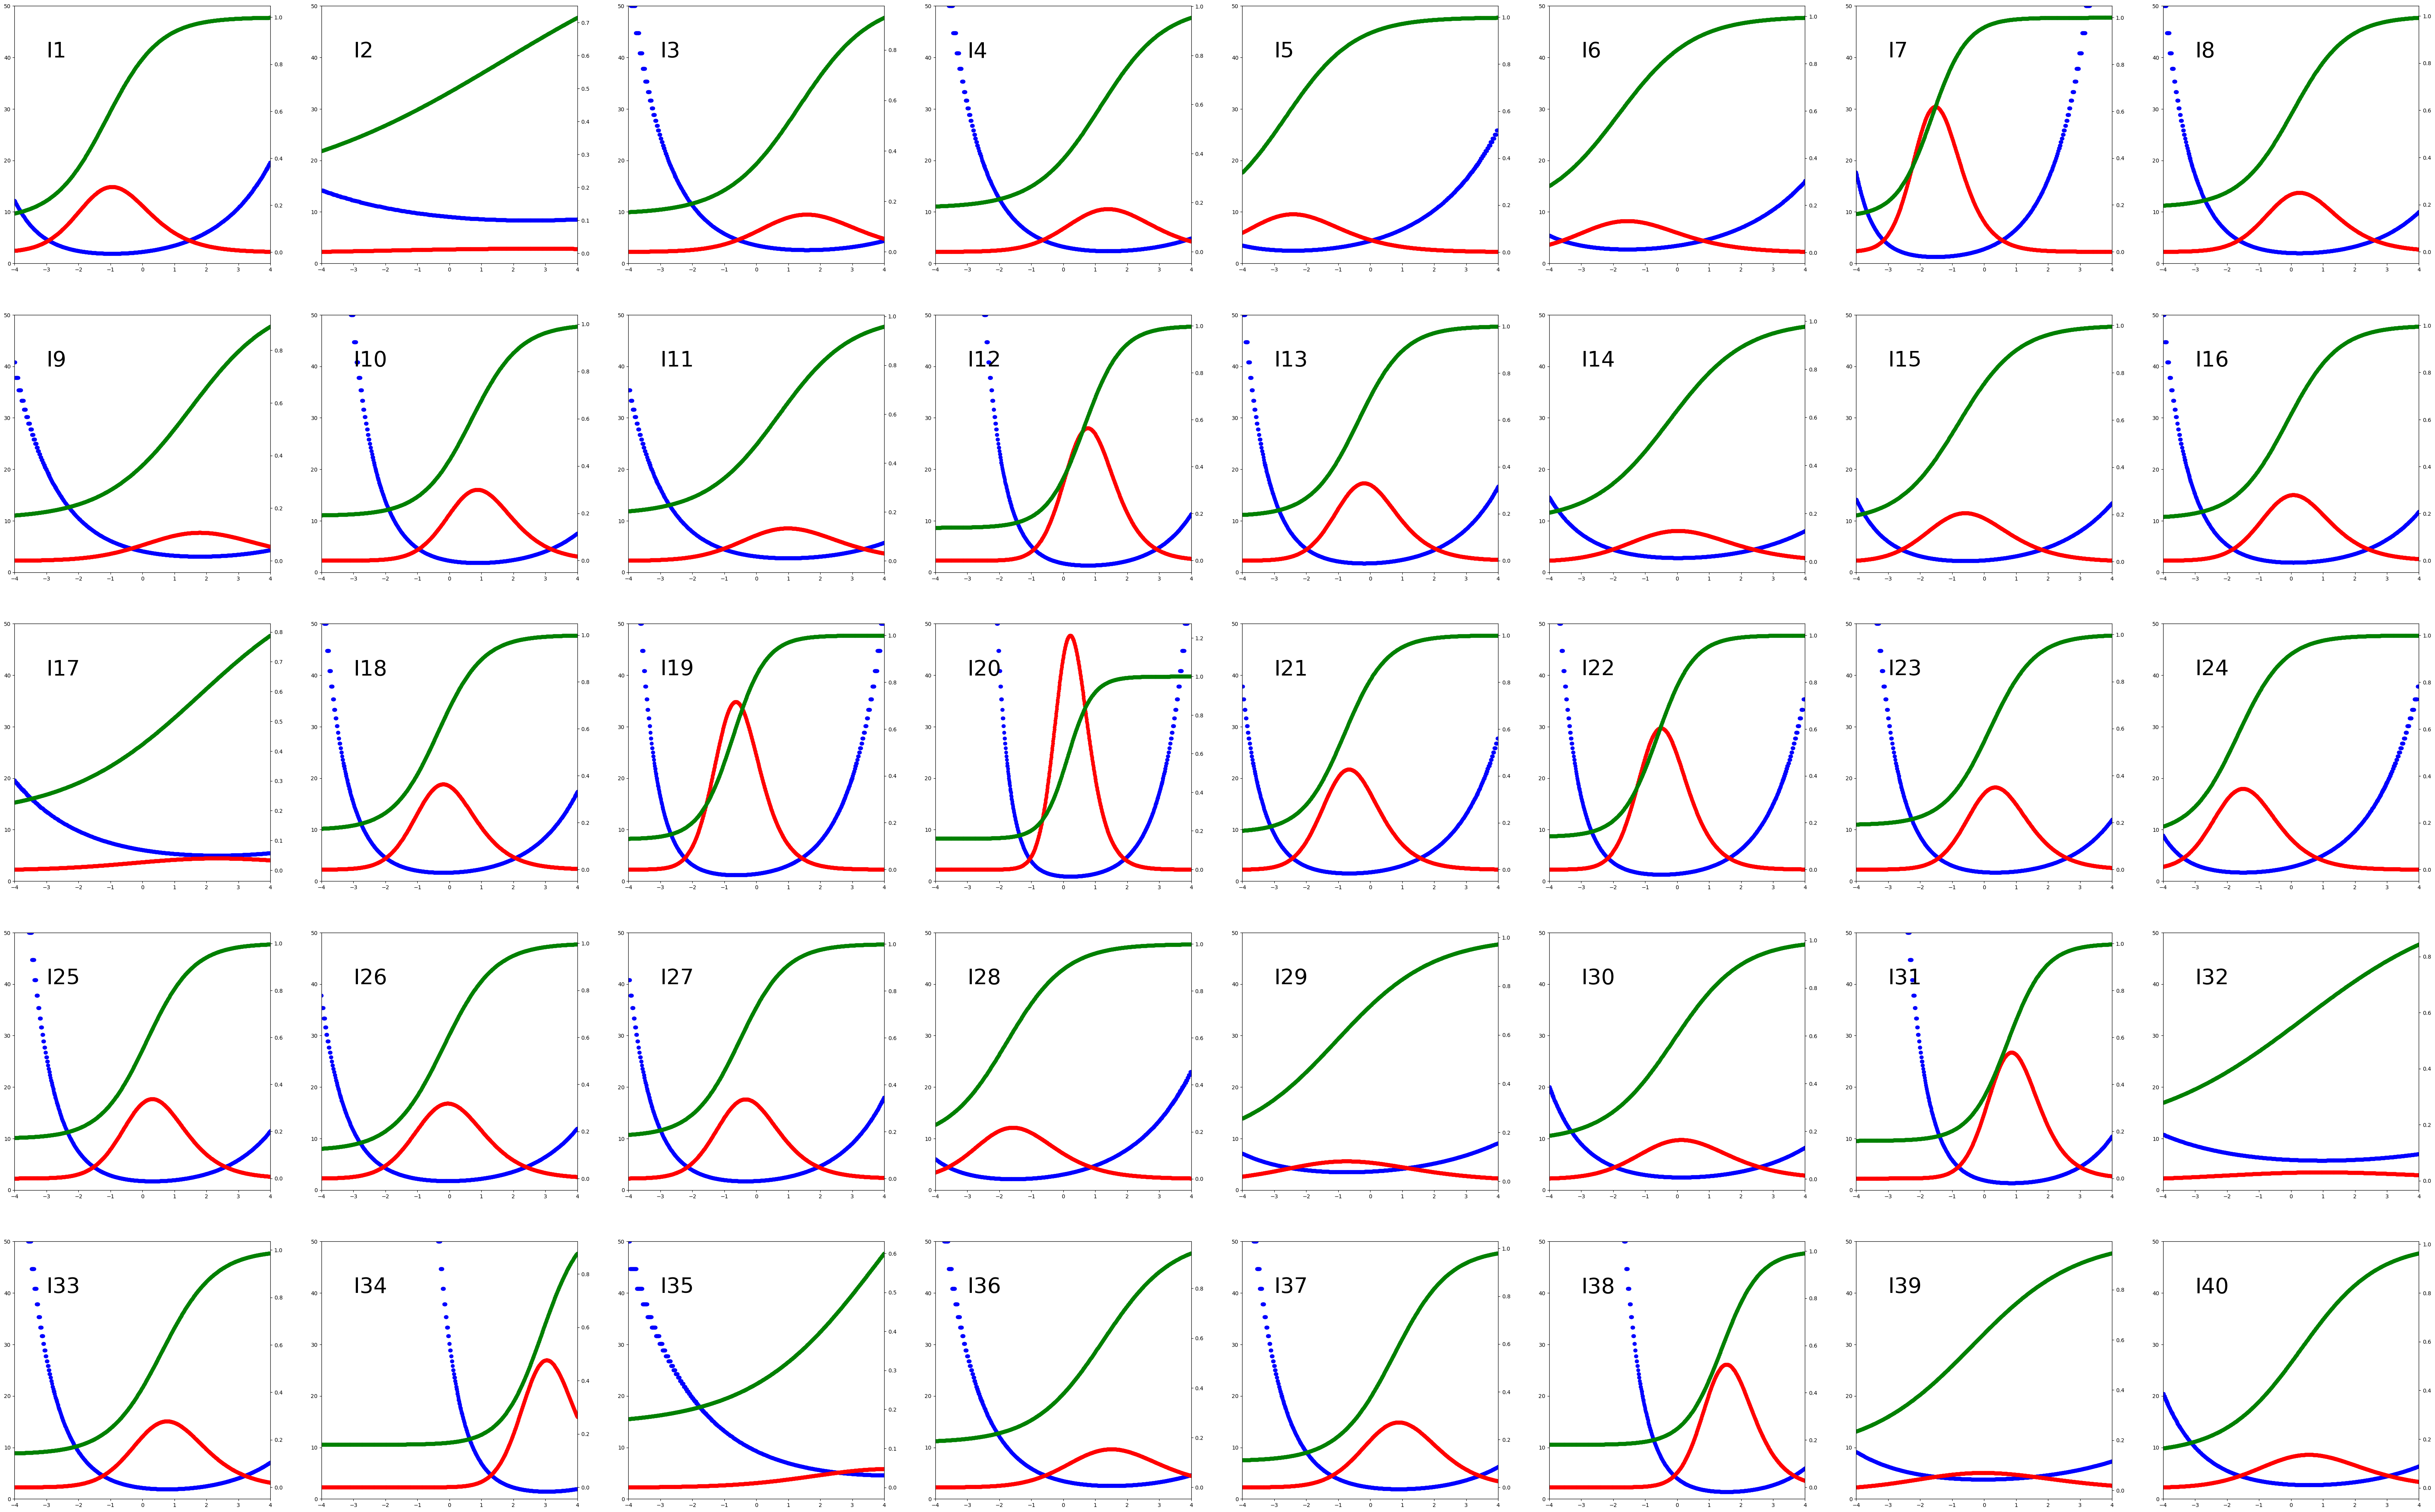

In [194]:
fig , ax = plt.subplots(5, 8, figsize=(80, 50))

for count, i in enumerate(matrix_prob_1_ind):
    row = count // 8 # a really cool way to move from a row to the other
    col = count % 8
    item = "I" + str(count+1)
    ax[row, col].scatter(theta, SE.iloc[count,:], c = "blue") # I weighted by the default quadrature weights
    ax2 = ax[row, col].twinx() # duplicate to plot on the second axis
    ax2.scatter(theta, info.iloc[count,:], c = "red") # I weighted the obs by the vector of weighted posterior density across at each quadrature
    ax2.scatter(theta, matrix_prob_1_ind[count], c = "green") # The ICCs
    ax[row,col].text(-3, 40 , item, size = 40)   
    ax[row,col].axis(xmin = -4, xmax = 4, ymin = 0, ymax = 50)
    

Also, when we zoom in on Item 34 the most difficult item and item 5 the easiest item below, we can see that the information peaks at really low values of abilities for item 5 because of its easiness. On the other hand, the information peaks at higher values of ability for item 34 because of its difficulty.

The other thing we notice is that the slope of the ICC of Item 5 at the ability of maximum information is less steep than the slope of Item 34 which justifies why the information function height is higher for item 34 than for Item 5. That means Item 34 discriminates at that ability more than Item 5 discriminates between examinees at the correspondent ability.

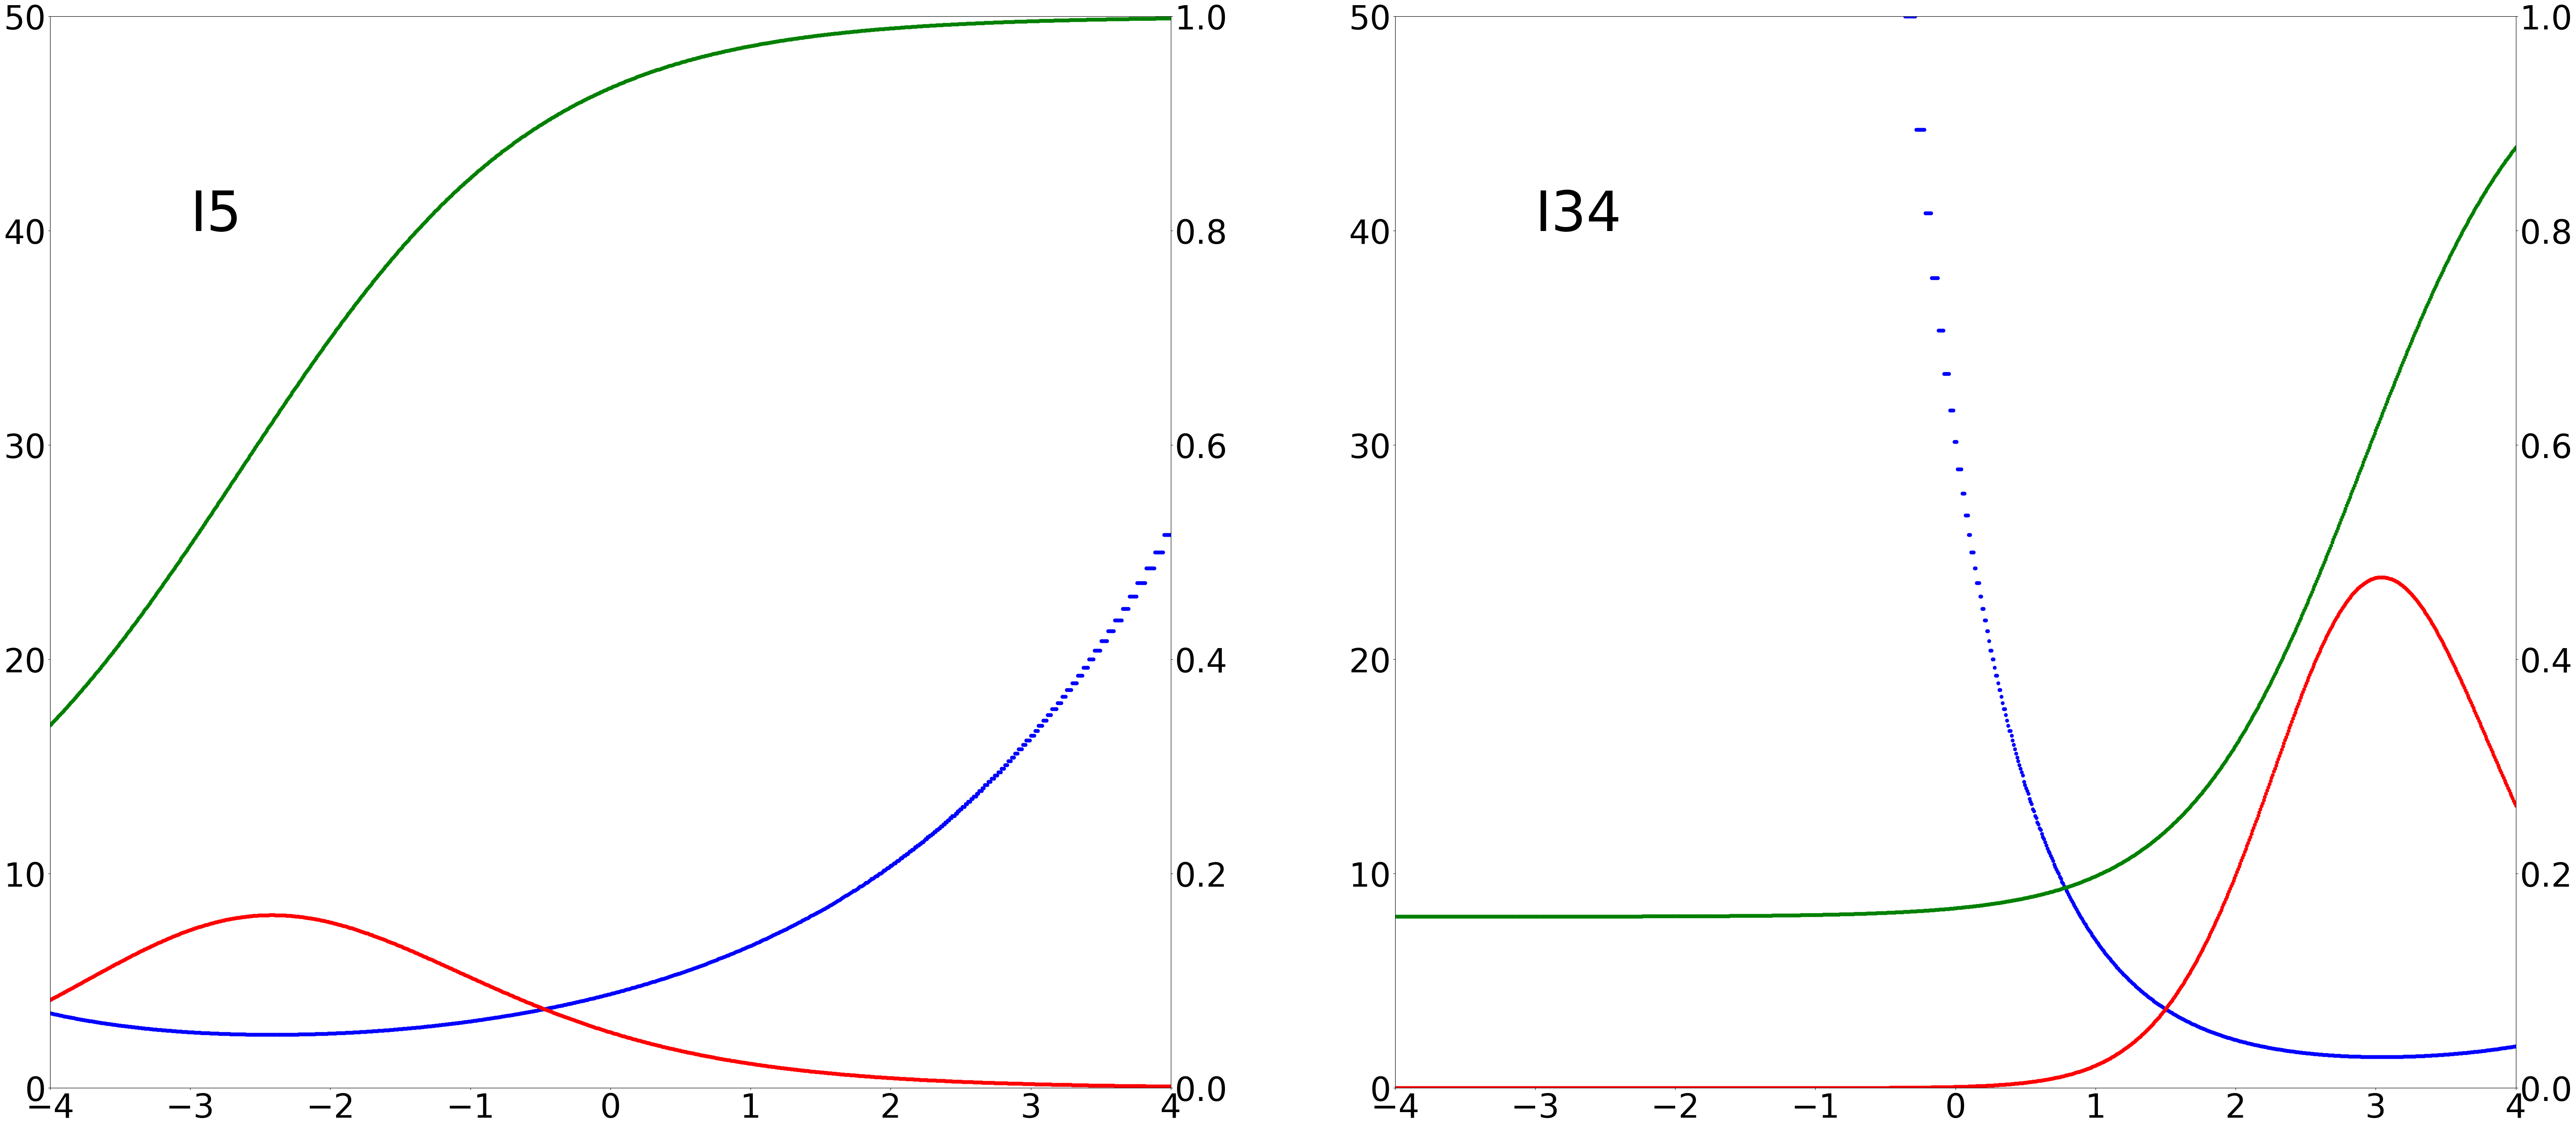

In [204]:
fig , ax = plt.subplots(1, 2, figsize=(80, 35))

for count, i in enumerate([4, 33]):
    row = count // 2 # a really cool way to move from a row to the other
    col = count % 2
    item = "I" + str(i+1)
    ax[col].scatter(theta, SE.iloc[i,:], c = "blue") # I weighted by the default quadrature weights
    ax2 = ax[col].twinx() # duplicate to plot on the second axis
    ax2.scatter(theta, info.iloc[i,:], c = "red") # I weighted the obs by the vector of weighted posterior density across at each quadrature
    ax2.scatter(theta, matrix_prob_1_ind[i], c = "green") # The ICCs
    ax[col].text(-3, 40 , item, size = 100)   
    ax[col].axis(xmin = -4, xmax = 4, ymin = 0, ymax = 50)
    ax[col].tick_params(axis = "both", which = "major", labelsize=60)
    ax2.tick_params(axis = "both", which = "major", labelsize=60)
    ax2.axis(xmin = -4, xmax = 4, ymin = 0, ymax = 1)

Finally the marginal reliability of for the EAP scores is 0.86. Therefore, 86% of the variance in the EAP scores is attributable to the true differences in the latent trait being measured in the AMEX test, while the remaining 14% reflects measurement error.